In [32]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib

from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score, \
                            auc, confusion_matrix, accuracy_score, \
                            classification_report

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.pipeline import Pipeline
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
df_data_general = pd.read_csv('../../../data/data_general.csv')

In [3]:
df_data_general['INITIAL_TIME'] = pd.to_datetime(df_data_general['INITIAL_TIME'])
df_data_general['FINAL_TIME'] = pd.to_datetime(df_data_general['FINAL_TIME'])

In [4]:
df_data_general['INITIAL_TIME'] = df_data_general['INITIAL_TIME'].dt.to_period('D')
df_data_general['INITIAL_TIME'] = df_data_general['INITIAL_TIME'].dt.to_timestamp()


df_data_general['FINAL_TIME'] = df_data_general['FINAL_TIME'].dt.to_period('D')
df_data_general['FINAL_TIME'] = df_data_general['FINAL_TIME'].dt.to_timestamp()

In [5]:
df_data_general['Weekday']= df_data_general['INITIAL_TIME'].dt.strftime('%A')
df_data_general['number_of_day'] = df_data_general['INITIAL_TIME'].dt.day_of_week

In [11]:
df_data_general['NET_SPEND'] = df_data_general['FINAL_AMOUNT'] - df_data_general['INITIAL_AMOUNT']
df_data_general['WON_CASINO'] = df_data_general['NET_SPEND'] < 0

In [12]:
df_data_general[['number_of_day', 'INITIAL_AMOUNT', 'BET_TOTAL', 'TIME_ON_DEVICE_SEC', 'GAMES_PLAYED_TOTAL', 'NET_SPEND']].corr(method='spearman')

,number_of_day,INITIAL_AMOUNT,BET_TOTAL,TIME_ON_DEVICE_SEC,GAMES_PLAYED_TOTAL,NET_SPEND
number_of_day,1.00,0.01,0.01,0.02,0.01,-0.01
INITIAL_AMOUNT,0.01,1.00,0.45,0.17,0.20,-0.35
BET_TOTAL,0.01,0.45,1.00,0.80,0.85,-0.43
TIME_ON_DEVICE_SEC,0.02,0.17,0.80,1.00,0.93,-0.16
GAMES_PLAYED_TOTAL,0.01,0.20,0.85,0.93,1.00,-0.27
NET_SPEND,-0.01,-0.35,-0.43,-0.16,-0.27,1.00


In [13]:
df_data_general['TIME_ON_DEVICE_MIN'] = df_data_general['TIME_ON_DEVICE_SEC'] / 60

In [14]:
df_data_general['Hour'] = df_data_general['INITIAL_TIME'].dt.hour
df_data_general['Weekday'] = df_data_general['INITIAL_TIME'].dt.weekday   # 0=Lunes, 6=Domingo
df_data_general['Weekend'] = (df_data_general['Weekday'] >= 5).astype(int)
df_data_general['Month'] = df_data_general['INITIAL_TIME'].dt.month

In [21]:
df_data_general = df_data_general[df_data_general['TIME_ON_DEVICE_MIN'] < 600 ]
df_data_general = df_data_general[df_data_general['NET_SPEND'] < 10000 ]

In [22]:
features = ['INITIAL_AMOUNT','AVG_BET','Cluster', 'BET_TOTAL']

X = df_data_general[features]
y = df_data_general['NET_SPEND']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predicción
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MAE: 195.31740564181402
R2: 0.05499674931564458


In [23]:
std_scaler = StandardScaler()
pipe = Pipeline([
        ('scaler', std_scaler),
        ('reg', RandomForestRegressor())
    ])

pipe.fit(X_train, y_train)

y_hat = pipe.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_hat))
print("R2:", r2_score(y_test, y_hat))

MAE: 195.44769168121894
R2: 0.052330055489557825


In [24]:
# joblib.dump(pipe, '../../../models/win_total_pipeline_regressor_foliattiGeneral_v1.pkl')

<Axes: xlabel='NET_SPEND'>

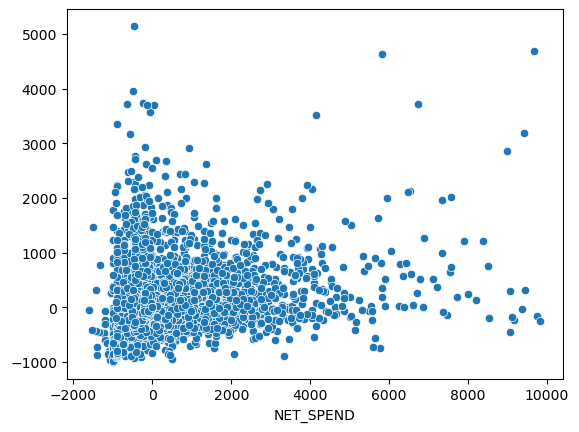

In [25]:
sns.scatterplot(x=y_test, y=y_hat)

In [ ]:
# pipe_class = Pipeline([
#     ("scaler", StandardScaler()),
#     ("knn", KNeighborsClassifier())
# ])

# param_grid = {
#     "knn__n_neighbors": range(1, 11)
# }

# grid = GridSearchCV(pipe_class, param_grid=param_grid, cv=2, refit=True)

# y = df_data_general['WON_CASINO']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52)
# grid.fit(X_train, y_train)
# y_hat_knn = grid.predict(X_test)
# print(classification_report(y_test, y_hat_knn))

              precision    recall  f1-score   support

       False       0.75      0.33      0.46     15100
        True       0.84      0.97      0.90     52888

    accuracy                           0.83     67988
   macro avg       0.79      0.65      0.68     67988
weighted avg       0.82      0.83      0.80     67988



In [ ]:
# print("Mejor k:", grid.best_params_)
# print("Mejor score:", grid.best_score_)

Mejor k: {'knn__n_neighbors': 9}
Mejor score: 0.8270516979849315


In [43]:
false_df = df_data_general[df_data_general['WON_CASINO'] == False]
true_df  = df_data_general[df_data_general['WON_CASINO'] == True]

# Submuestreo de la clase mayoritaria (True) al tamaño de la minoritaria (False)
true_sample = true_df.sample(n=len(false_df), random_state=42)

# Unir ambas
df_balanced = pd.concat([false_df, true_sample])

# Mezclar
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [48]:
pipe_class = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=9))
])
X = df_balanced[features]
y = df_balanced['WON_CASINO']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52)
pipe_class.fit(X_train, y_train)
y_hat_knn = pipe_class.predict(X_test)
print(classification_report(y_test, y_hat_knn))

              precision    recall  f1-score   support

       False       0.69      0.62      0.65     15047
        True       0.65      0.72      0.69     14998

    accuracy                           0.67     30045
   macro avg       0.67      0.67      0.67     30045
weighted avg       0.67      0.67      0.67     30045

